In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox #https://github.com/aashwinmishra/lcls_beamline_optimization

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3287, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 3287 (delta 487), reused 427 (delta 365), pack-reused 2729
Receiving objects: 100% (3287/3287), 232.16 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (2537/2537), done.
Updating files: 100% (144/144), done.


In [2]:
# !pip install -U setuptools
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install botorch -q
!pip install xopt -q
# !pip install xrt -q

Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.4 MB/s eta 0:00:00
  Created wheel for xrt: filename=xrt-1.6.0-py3-none-any.whl size=5455911 sha256=7e556fa8ebff7de5de91c577012195b5bd2dcccfe43cfd75e562ea8693694a02
  Stored in directory: /root/.cache/pip/wheels/1c/47/52/d81d20e573b667bde10001744414b40202bef04daae4b2081d
Successfully built xrt
  Running setup.py develop for lcls-beamline-toolbox
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.0/625

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

import torch
import gpytorch
import botorch
# from botorch.models import SingleTaskGP, ModelListGP
# from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
# from botorch import fit_gpytorch_model
# from botorch.utils.multi_objective.pareto import is_non_dominated
# from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
# from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
# from botorch.models.model_list_gp_regression import ModelListGP
# from botorch.acquisition.analytic import ExpectedImprovement
# from botorch.acquisition.multi_objective.analytic import ExpectedHypervolumeImprovement
# from botorch.optim.optimize import optimize_acqf

import warnings
warnings.filterwarnings("ignore")



from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

In [4]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    # snd.mvr_t1_chi1(x[2])#not in study 1
    # snd.mvr_t1_chi2(x[3])#not in study 1
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    # snd.mvr_t4_chi1(x[6])#not in study 1
    # snd.mvr_t4_chi2(x[7])#not in study 1

    # snd.mvr_t1_th1(x[0])
    # snd.mvr_t1_th2(x[1])
    # snd.mvr_t4_th1(x[2])
    # snd.mvr_t4_th2(x[3])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    result.append([(my_intensity)/(62186.2678), np.log(np.abs(do_centroid_x))/(-16.86781883239746), np.log(np.abs(do_centroid_y))/(-17.84674644470215)])
    del snd
  return torch.tensor(result, dtype=torch.float)

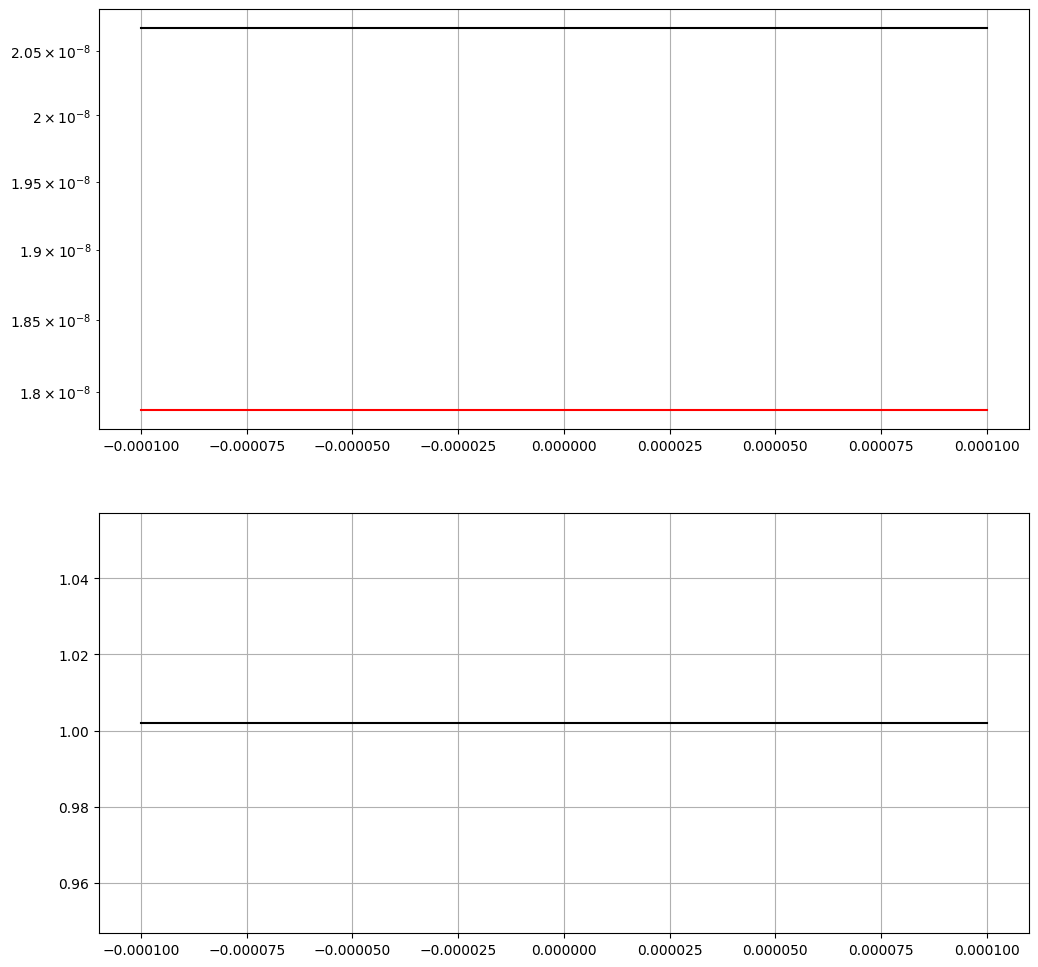

In [39]:
nscan = 250
ndim = 3
inp = np.ones((nscan,8))*0.500
scanner = np.linspace(0,1, nscan)
inp[:, ndim] = scanner
ys = get_snd_outputs(inp).squeeze()
x_scan = scanner*200e-6 - 100e-6
result1, result2, result3 = ys[:, 0], ys[:,1], ys[:,2]

fig, axs = plt.subplots(2, figsize=(12,12))
axs[0].plot(x_scan, np.exp(-result2*16.86), 'k')
axs[0].plot(x_scan, np.exp(-result3*17.84), 'r')
axs[0].set_yscale("log")
axs[0].grid()

axs[1].plot(x_scan, result1, 'k')
axs[1].grid()

# axs[2].plot(x_scan, result1*result2,'k')

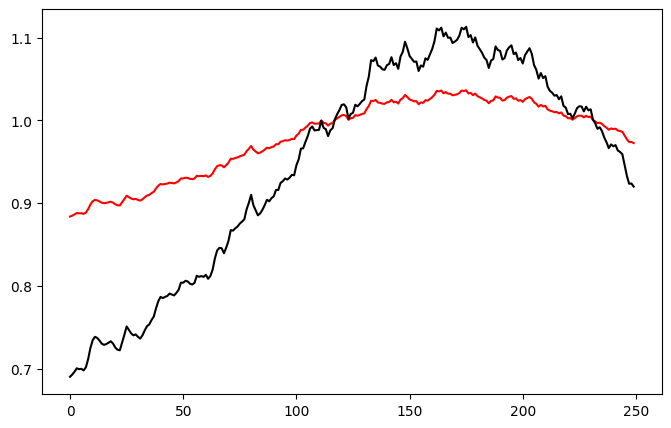

In [29]:
plt.figure(figsize=(8,5))

scale1 = 62186.2678
plt.plot(result1, 'r')
plt.plot(np.power(result1, 3), 'k')

plt.show()

In [7]:
ys = get_snd_outputs(np.ones((1,8))*0.500).squeeze()
print(ys[0], ys[1], ys[2])

tensor(1.0020) tensor(1.0495) tensor(1.)


In [11]:
ys = get_snd_outputs(np.zeros((1,8))).squeeze()
print(ys[0].item(), ys[1].item(), ys[2].item())

0.0007122014067135751 0.49176642298698425 0.4647921025753021


In [5]:
def eval_function(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f1, f2, f3 =  output[0].item(), output[1].item(), output[2].item()
  del output, Xinp
  return {"f1": f1, "f2": f2, "f3": f3}

In [6]:
def run_chain(eval_function = eval_function, n_init: int=5, n_steps: int = 60):
  low = 0.01
  high = 0.99
  vocs = VOCS(
    variables = {"x1": [low, high],
                 "x2": [low, high],
                 "x3": [low, high],
                 "x4": [low, high],
                 "x5": [low, high],
                 "x6": [low, high],
                 "x7": [low, high],
                 "x8": [low, high]},
    objectives = {"f1": "MAXIMIZE", "f2": "MAXIMIZE", "f3": "MAXIMIZE"},
  )
  np.random.seed(42)
  gigo = np.random.rand(8)
  evaluator = Evaluator(function=eval_function)
  ref_point = eval_function({"x1": gigo[0], "x2": gigo[1], "x3": gigo[2],
                             "x4": gigo[3], "x5": gigo[4], "x6": gigo[5],
                             "x7": gigo[6], "x8": gigo[7]})
  generator = MOBOGenerator(vocs=vocs, reference_point= ref_point)
  generator.n_monte_carlo_samples = 512
  generator.numerical_optimizer.n_restarts = 80
  X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
  X.random_evaluate(n_init)
  for i in range(n_steps):
    print(i)
    X.step()

  y1 = X.generator.data["f1"]
  y2 = X.generator.data["f2"]
  y3 = X.generator.data["f3"]
  y1_maxs = np.maximum.accumulate(y1)
  y2_maxs = np.maximum.accumulate(y2)
  y3_maxs = np.maximum.accumulate(y3)

  del vocs, evaluator, ref_point, generator, X

  return y1, y2, y3 #y1_maxs, y2_maxs, y3_maxs

In [7]:
def run_ensemble(n_chains: 25, eval_function = eval_function, n_init: int=3, n_steps: int = 50):
  y1s = []
  y2s = []
  y3s = []
  for i in range(n_chains):
    print(f"Chain: {i+1} of {n_chains}")
    y1, y2, y3 = run_chain(eval_function = eval_function, n_init=n_init, n_steps = n_steps)
    y1s.append(y1)
    y2s.append(y2)
    y3s.append(y3)

  return np.array(y1s), np.array(y2s), np.array(y3s)

In [ ]:
result1, result2, result3 = run_chain(n_init=5, n_steps=80)

0
1


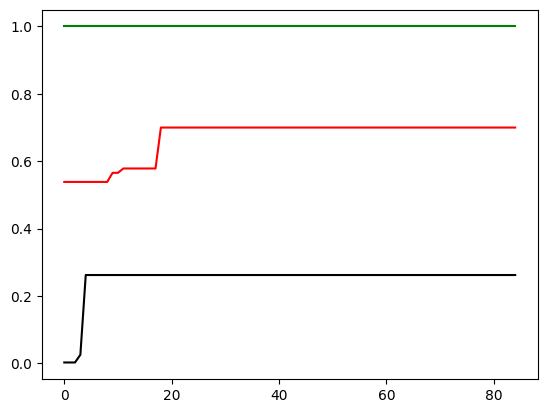

In [44]:
plt.plot(result1, 'k')
plt.plot(result2, 'r')
plt.plot(result3, 'g')

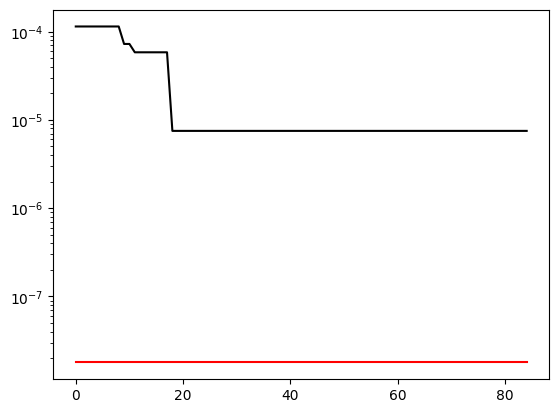

In [45]:
plt.plot(np.exp(-result2*16.86), 'k')
plt.plot(np.exp(-result3*17.84), 'r')
plt.yscale("log")

In [ ]:
!pip install minepy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.0/497.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from minepy import MINE

In [ ]:
low = 0.01
high = 0.99
vocs = VOCS(
    variables = {"x1": [low, high],
                 "x2": [low, high],
                 "x3": [low, high],
                 "x4": [low, high],
                 "x5": [low, high],
                 "x6": [low, high],
                 "x7": [low, high],
                 "x8": [low, high]},
    objectives = {"f1": "MAXIMIZE", "f2": "MAXIMIZE", "f3": "MAXIMIZE"},
)
vocs

VOCS(variables={'x1': [0.01, 0.99], 'x2': [0.01, 0.99], 'x3': [0.01, 0.99], 'x4': [0.01, 0.99], 'x5': [0.01, 0.99], 'x6': [0.01, 0.99], 'x7': [0.01, 0.99], 'x8': [0.01, 0.99]}, constraints={}, objectives={'f1': 'MAXIMIZE', 'f2': 'MAXIMIZE', 'f3': 'MAXIMIZE'}, constants={}, observables=[])

In [ ]:
evaluator = Evaluator(function=eval_function)
evaluator

Evaluator(function=<function eval_function at 0x7f1f9807c160>, max_workers=1, executor=NormalExecutor[DummyExecutor](loader=ObjLoader[DummyExecutor](object=None, loader=CallableModel(callable=<class 'xopt.evaluator.DummyExecutor'>, signature=Kwargs_DummyExecutor(args=[], kwarg_order=[])), object_type=<class 'xopt.evaluator.DummyExecutor'>), executor_type=<class 'xopt.evaluator.DummyExecutor'>, submit_callable='submit', map_callable='map', shutdown_callable='shutdown', executor=<xopt.evaluator.DummyExecutor object at 0x7f1f9594bd60>), function_kwargs={}, vectorized=False)

In [ ]:
ref_point = eval_function({"x1": 0.65, "x2": 0.65, "x3": 0.65, "x4": 0.65, "x5": 0.65, "x6": 0.65, "x7": 0.65, "x8": 0.65})
ref_point

{'f1': 0.009041455574333668,
 'f2': 0.0002497558598406613,
 'f3': 0.0002497558598406613}

In [ ]:
generator = MOBOGenerator(vocs=vocs, reference_point= ref_point)
generator

MOBOGenerator(supports_batch_generation=False, supports_multi_objective=True, vocs=VOCS(variables={'x1': [0.01, 0.99], 'x2': [0.01, 0.99], 'x3': [0.01, 0.99], 'x4': [0.01, 0.99], 'x5': [0.01, 0.99], 'x6': [0.01, 0.99], 'x7': [0.01, 0.99], 'x8': [0.01, 0.99]}, constraints={}, objectives={'f1': 'MAXIMIZE', 'f2': 'MAXIMIZE', 'f3': 'MAXIMIZE'}, constants={}, observables=[]), data=None, model=None, n_monte_carlo_samples=128, turbo_controller=None, use_cuda=False, gp_constructor=StandardModelConstructor(name='standard', use_low_noise_prior=True, covar_modules={}, mean_modules={}, trainable_mean_keys=[], transform_inputs=True, custom_noise_prior=None), numerical_optimizer=LBFGSOptimizer(name='LBFGS', n_restarts=20, max_iter=2000, max_time=None), max_travel_distances=None, fixed_features=None, computation_time=None, log_transform_acquisition_function=False, n_interpolate_points=None, n_candidates=1, reference_point={'f1': 0.009041455574333668, 'f2': 0.0002497558598406613, 'f3': 0.0002497558598

In [ ]:
generator.n_monte_carlo_samples = 256
generator.numerical_optimizer.n_restarts = 40


X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.random_evaluate(500)
X.data

,x1,x2,x3,x4,x5,x6,x7,x8,f1,f2,f3,xopt_runtime,xopt_error
0,0.581197,0.211253,0.915438,0.888739,0.511628,0.310491,0.229443,0.743662,0.036182,0.000250,0.000250,0.363303,False
1,0.097843,0.686774,0.937406,0.371146,0.079611,0.215724,0.201830,0.709126,0.001118,0.000250,0.000250,0.362932,False
2,0.331614,0.931162,0.755337,0.351158,0.620054,0.446019,0.388632,0.799975,0.006789,0.000250,0.000250,0.345599,False
3,0.459226,0.551405,0.963771,0.313111,0.916100,0.277198,0.259829,0.524203,0.228160,0.000250,0.000250,0.347032,False
4,0.393154,0.035396,0.573712,0.388593,0.414589,0.840294,0.434290,0.324454,0.018727,0.000250,0.000250,0.351799,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.800946,0.099143,0.400873,0.802304,0.778211,0.445209,0.598474,0.920041,0.002020,0.000250,0.000250,0.342334,False
496,0.233181,0.942256,0.590206,0.837968,0.638902,0.982532,0.965255,0.066413,0.002599,0.000250,0.000250,0.334328,False
497,0.746562,0.654267,0.715454,0.432280,0.888920,0.242553,0.871039,0.599723,0.003072,0.000250,0.000250,0.345446,False
498,0.732761,0.375587,0.797230,0.913438,0.742404,0.071199,0.675198,0.620174,0.003438,0.000250,0.000250,0.358220,False


In [ ]:
def get_mic(x, y):
  mine = MINE(alpha=0.6, c=15, est="mic_approx")
  mine.compute_score(x, y)
  MIC=mine.mic()
  return MIC

In [ ]:
mics = []
for x in ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]:
  mic = get_mic(X.generator.data[x], X.generator.data["f2"])
  print(x, ": ",mic)
  mics.append(mic)

x1 :  0.23040581026555454
x2 :  0.17555432706999746
x3 :  0.22485101268722
x4 :  0.17986584147468482
x5 :  0.1661992845505497
x6 :  0.20297927507782904
x7 :  0.2406029611438286
x8 :  0.2463662983675769


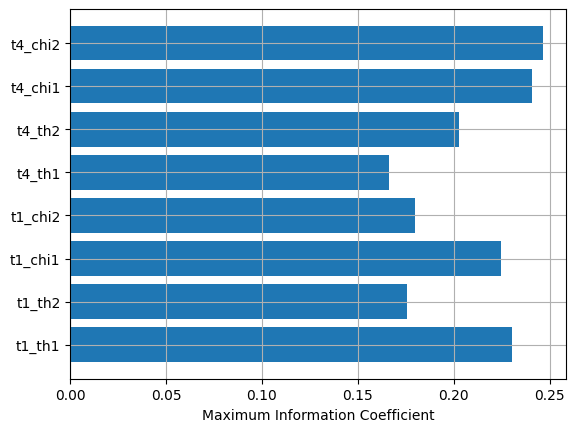

In [ ]:
labels = ["t1_th1", "t1_th2", "t1_chi1", "t1_chi2", "t4_th1", "t4_th2", "t4_chi1", "t4_chi2"]
plt.barh(labels, mics)
plt.grid()
plt.xlabel("Maximum Information Coefficient");

In [ ]:
mics = []
for x in ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]:
  mic = get_mic(X.generator.data[x], X.generator.data["f3"])
  print(x, ": ",mic)
  mics.append(mic)

x1 :  0.23040581026555454
x2 :  0.17555432706999746
x3 :  0.22485101268722
x4 :  0.17986584147468482
x5 :  0.1661992845505497
x6 :  0.20297927507782904
x7 :  0.2406029611438286
x8 :  0.2463662983675769


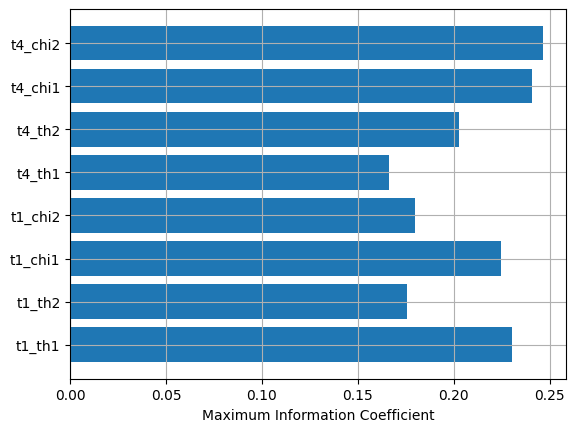

In [ ]:
labels = ["t1_th1", "t1_th2", "t1_chi1", "t1_chi2", "t4_th1", "t4_th2", "t4_chi1", "t4_chi2"]
plt.barh(labels, mics)
plt.grid()
plt.xlabel("Maximum Information Coefficient");

x1 :  0.14982888109590267
x2 :  0.12823371173932382
x3 :  0.13677777378743342
x4 :  0.14891999845259027
x5 :  0.15735753133567512
x6 :  0.13587136262439006
x7 :  0.14181071320473806
x8 :  0.13145965973399104


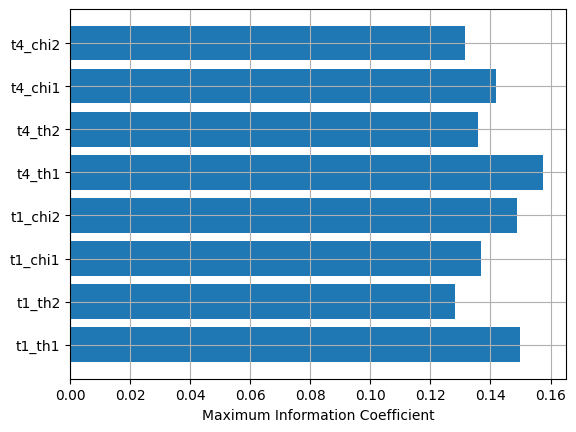

In [ ]:
mics = []
for x in ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]:
  mic = get_mic(X.generator.data[x], X.generator.data["f3"])
  print(x, ": ",mic)
  mics.append(mic)
labels = ["t1_th1", "t1_th2", "t1_chi1", "t1_chi2", "t4_th1", "t4_th2", "t4_chi1", "t4_chi2"]
plt.barh(labels, mics)
plt.grid()
plt.xlabel("Maximum Information Coefficient");

x1 :  0.14982888109590267
x2 :  0.12823371173932382
x3 :  0.13677777378743342
x4 :  0.14891999845259027
x5 :  0.15735753133567512
x6 :  0.13587136262439006
x7 :  0.14181071320473806
x8 :  0.13145965973399104


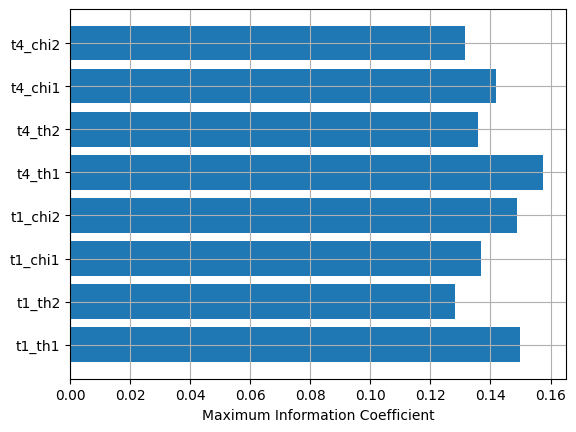

In [ ]:
mics = []
for x in ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]:
  mic = get_mic(X.generator.data[x], X.generator.data["f2"])
  print(x, ": ",mic)
  mics.append(mic)
labels = ["t1_th1", "t1_th2", "t1_chi1", "t1_chi2", "t4_th1", "t4_th2", "t4_chi1", "t4_chi2"]
plt.barh(labels, mics)
plt.grid()
plt.xlabel("Maximum Information Coefficient");

x1 :  1.0000000000000002
x2 :  0.16781058195430584
x3 :  0.15825754572267126
x4 :  0.14918397497082692
x5 :  0.15679242558805917
x6 :  0.1533493338459792
x7 :  0.16108828313412638
x8 :  0.153181989980793


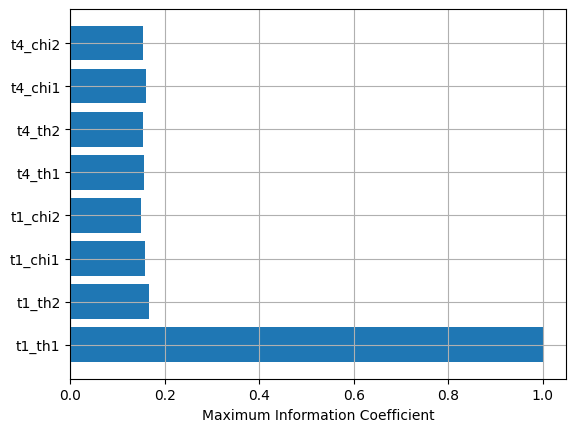

In [ ]:
mics = []
for x in ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]:
  mic = get_mic(X.generator.data[x], X.generator.data["f1"])
  print(x, ": ",mic)
  mics.append(mic)
labels = ["t1_th1", "t1_th2", "t1_chi1", "t1_chi2", "t4_th1", "t4_th2", "t4_chi1", "t4_chi2"]
plt.barh(labels, mics)
plt.grid()
plt.xlabel("Maximum Information Coefficient");

In [ ]:
for i in range(100):
  print(i)
  X.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
X.generator.data

,x1,x2,x3,x4,x5,x6,x7,x8,f1,f2,xopt_runtime,xopt_error
0,0.280899,0.618092,0.387023,0.676390,0.721505,0.619388,0.561077,0.258912,0.003843,0.473094,0.605604,False
1,0.403506,0.423805,0.744354,0.675219,0.703456,0.619884,0.466891,0.395147,0.025021,0.491633,0.325034,False
2,0.465592,0.324839,0.750000,0.674756,0.694763,0.620217,0.418410,0.464523,0.234990,0.478840,0.385248,False
3,0.379005,0.264380,0.750000,0.675566,0.715293,0.619437,0.506628,0.387651,0.027855,0.476867,0.316340,False
4,0.477045,0.434754,0.749671,0.674796,0.694662,0.620216,0.411454,0.476296,0.945371,0.512590,0.415459,False
...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.609380,0.577010,0.453188,0.250473,0.263302,0.432865,0.481349,0.397988,0.018088,0.473094,0.312028,False
98,0.685235,0.651930,0.596292,0.692240,0.646119,0.375941,0.253942,0.285114,0.005653,0.485858,0.310415,False
99,0.721477,0.317078,0.427456,0.380799,0.462456,0.363041,0.520948,0.630091,0.003754,0.473094,0.309342,False
100,0.685059,0.391987,0.553286,0.641736,0.308687,0.386867,0.643863,0.323220,0.005597,0.473094,0.308407,False


In [ ]:
y1 = X.generator.data["f1"]
y2 = X.generator.data["f2"]

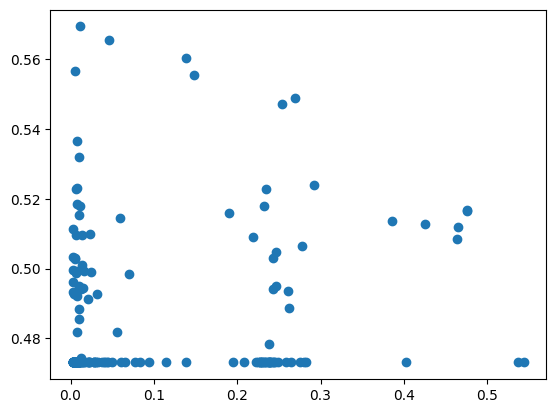

In [ ]:
plt.scatter(y1, y2)

In [ ]:
scale1, scale2 = 62186.2678, 16.801

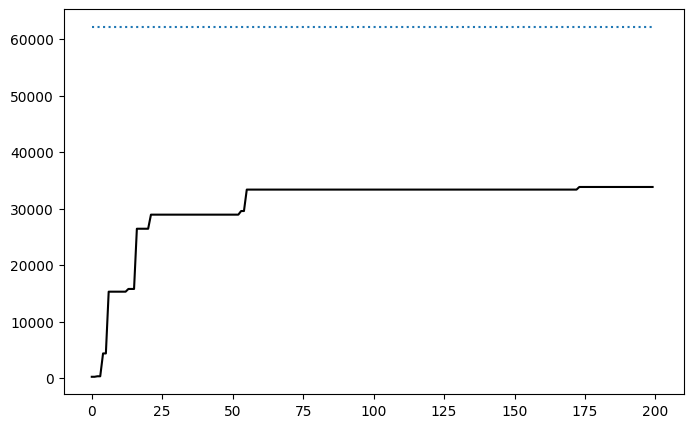

In [ ]:
plt.figure(figsize=(8,5))

scale1 = 62186.2678
y1_maxs = np.maximum.accumulate(y1)
y2_maxs = np.maximum.accumulate(y2)
plt.plot(y1_maxs*scale1, 'k')
plt.hlines(scale1, 0, len(y1_maxs), linestyles="dotted")


plt.show()

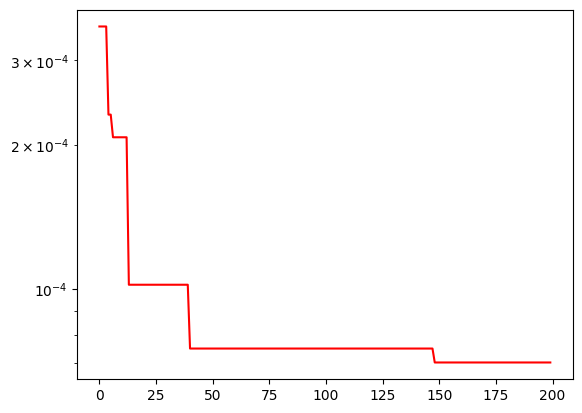

In [ ]:
plt.plot(np.exp(-y2_maxs*scale2), 'r')
plt.yscale("log")

In [ ]:
y2_maxs.shape

(80,)

In [ ]:
temp = np.stack([y1_maxs, y2_maxs])
temp.shape

(2, 80)

In [ ]:
t = [y1_maxs, y2_maxs]
temp = np.array(t)
temp.shape

(2, 80)

In [ ]:
model = generator.train_model()

In [ ]:
model

ModelListGP(
  (models): ModuleList(
    (0-1): 2 x SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): MaternKernel(
          (lengthscale_prior): GammaPrior()
          (raw_lengthscale_constraint): Positive()
        )
        (outputscale_prior): GammaPrior()
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
  )
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
)

In [50]:
gigo = np.random.rand(8)
print(gigo)
print(gigo[0], gigo[1])

[0.3258822  0.37098843 0.70276606 0.40218955 0.91538362 0.85318977
 0.80208197 0.28037045]
0.3258821975163626 0.3709884340293853
